<a href="https://colab.research.google.com/github/clmeyer5/Group6-Bioauthentication-EEE598-Class/blob/main/XGBoost_sEMG_Authintication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Physionet Waveform-database
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 57.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [2]:
# 1) Authenticate to your Google account
from google.colab import auth
auth.authenticate_user()

# 2) Build the Drive client
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
import io, re

drive = build('drive', 'v3')

# 3) Paste your Drive sharing URL (any of the common formats)
url = "https://drive.google.com/file/d/1oaq6MV0GVzM0JPeBfglFGeCFEyFTF8YC/view?usp=drive_link"  # <-- replace

# Extract the file ID from common URL patterns
m = re.search(r'/d/([a-zA-Z0-9_-]+)', url) or re.search(r'id=([a-zA-Z0-9_-]+)', url)
file_id = m.group(1) if m else url  # fall back if someone pasted the raw ID

# (Optional) Check name & mimeType (also helps if it’s in a Shared drive)
meta = drive.files().get(fileId=file_id, fields="name, mimeType, size",
                         supportsAllDrives=True).execute()
print("Downloading:", meta["name"], meta.get("size", "?"), "bytes")

# 4) Stream the download to disk (robust for large files)
zip_path = "/content/data.zip"
request = drive.files().get_media(fileId=file_id)
fh = io.FileIO(zip_path, "wb")
downloader = MediaIoBaseDownload(fh, request)
done = False
while not done:
    status, done = downloader.next_chunk()
    if status:
        print(f"Progress: {int(status.progress() * 100)}%")
fh.close()

# 5) Unzip
!mkdir -p /content/data
!unzip -q /content/data.zip -d /content/data
!ls -lah /content/data | head -n 20

HttpError: <HttpError 404 when requesting https://www.googleapis.com/drive/v3/files/1oaq6MV0GVzM0JPeBfglFGeCFEyFTF8YC?fields=name%2C+mimeType%2C+size&supportsAllDrives=true&alt=json returned "File not found: 1oaq6MV0GVzM0JPeBfglFGeCFEyFTF8YC.". Details: "[{'message': 'File not found: 1oaq6MV0GVzM0JPeBfglFGeCFEyFTF8YC.', 'domain': 'global', 'reason': 'notFound', 'location': 'fileId', 'locationType': 'parameter'}]">

# XGBoost Tweaks

In [ ]:
# ============================================================
# PATCH: Better features + Z-norm + Top-K/Trim aggregation + Threshold sweep
#  - Adds z-normalized distances and correlation eigenvalues per ring
#  - Uses XGBoost with a monotone prior on the fused score
#  - Calibrates τ on a DEV split (train users only), with a printed FAR/FRR table
#  - Evaluates on Session 3 using Top-K + trimmed mean per trial
# ============================================================

import numpy as np, re, pathlib, warnings, xgboost as xgb, wfdb
from sklearn.model_selection import GroupShuffleSplit
from scipy.signal import butter, sosfiltfilt
from numpy.lib.stride_tricks import as_strided
from numpy.linalg import eigh
from sklearn.covariance import LedoitWolf
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm
warnings.filterwarnings("ignore", category=RuntimeWarning)

# ---------------- CONFIG YOU MAY TWEAK ----------------
BASE_DIR = "/content/data/gesture-recognition-and-biometrics-electromyogram-grabmyo-1.1.0"

RINGS_TO_USE = ["WP","FD","FP"]      # strongest pair
BP_BAND      = (20, 450)
WIN_SEC, HOP_SEC = 0.35, 0.20
GATE_TOP     = 0.50
RANDOM_STATE = 13

FAR_TARGET          = 0.05    # dev-set FAR target used to pick τ; you can change after seeing the sweep
GESTURES_INCLUDE_EVAL =  {1,2,3,4,5,6,7,8,9,10,11,12,13,14,16}  # your chosen subset for S3 evaluation
MAX_WIN_PER_RECORD  = 30      # cap windows per trial after gating (keeps runtime/control)

TOPK_K              = 10      # Top-K windows per trial (None to disable)
TRIM_FRACTION       = 0.10    # then trim 10% low & 10% high before averaging (None to disable)

# Heuristic ring weights for fused score (used as a feature)
RING_WEIGHTS = {"WP":0.3, "FD":0.35, "FP":0.35, "WD":0.10}


In [ ]:
# ---------------- HELPERS (same ideas as before) ----------------
def normalize_base_dir(base_dir):
    p = pathlib.Path(base_dir)
    if (p/"Session1").exists(): return str(p)
    c = list(p.rglob("Session1"))
    return str(c[0].parent) if c else str(p)
BASE_DIR = normalize_base_dir(BASE_DIR)

def list_participants():
    d = pathlib.Path(BASE_DIR)/"Session1"
    pats=[]
    if d.exists():
        for sub in d.iterdir():
            m = re.search(r"session1_participant(\d+)", sub.name)
            if m: pats.append(int(m.group(1)))
    return sorted(set(pats))

def stems_for(pid, sessions):
    out=[]
    for s in sessions:
        d = pathlib.Path(BASE_DIR)/f"Session{s}"/f"session{s}_participant{pid}"
        if not d.exists(): continue
        for hea in sorted(d.glob("*.hea")):
            stem = hea.with_suffix("")
            # for all gesture
            #m = re.search(r"session(\d+)_participant(\d+)_gesture(\d+)_trial(\d+)$", stem.name)
            # for gesture1 only
            m = re.search(r"session(\d+)_participant(\d+)_gesture1_trial(\d+)$", stem.name)
            if not m: continue
            if GESTURES_INCLUDE_EVAL and s==3:
                g = int(m.group(3))
                if g not in GESTURES_INCLUDE_EVAL:
                    continue
            out.append(stem.as_posix())
    return out

def read_record(stem):
    data, fields = wfdb.rdsamp(stem); fs = int(fields["fs"])
    names = fields.get("sig_name", [f"ch{i}" for i in range(data.shape[1])])
    return data.astype(np.float32), names, fs

def ring_indices(names):
    F = [(i,int(re.findall(r'\d+', str(n))[0])) for i,n in enumerate(names) if str(n).upper().startswith("F") and re.findall(r'\d+', str(n))]
    W = [(i,int(re.findall(r'\d+', str(n))[0])) for i,n in enumerate(names) if str(n).upper().startswith("W") and re.findall(r'\d+', str(n))]
    F = [i for i,_ in sorted(F, key=lambda z:z[1])]
    W = [i for i,_ in sorted(W, key=lambda z:z[1])]
    FP, FD = F[:8], F[8:16] if len(F)>=16 else (F, [])
    WP, WD = W[:6], W[6:12] if len(W)>=12 else (W, [])
    rings = {"FP":FP, "FD":FD, "WP":WP, "WD":WD}
    return {k:v for k,v in rings.items() if len(v)>1}

def bandpass_car(data, fs, idx):
    sos = butter(4, BP_BAND, btype='bandpass', fs=fs, output='sos')
    X = sosfiltfilt(sos, data[:, idx], axis=0)
    X = X - X.mean(axis=1, keepdims=True)
    return X.astype(np.float32)

def cheap_env(X, fs, lp_hz=8.0):
    sos = butter(2, lp_hz, btype='low', fs=fs, output='sos')
    return sosfiltfilt(sos, np.abs(X), axis=0)

def strided_windows(X, win, hop):
    T, C = X.shape
    if T < win: return np.zeros((0,win,C), dtype=X.dtype)
    n = 1 + (T - win)//hop
    s0, s1 = X.strides
    return as_strided(X, shape=(n,win,C), strides=(hop*s0, s0, s1))

def gate_idx(env_ring, fs, win_s, hop_s, keep_top=0.5):
    win, hop = int(win_s*fs), int(hop_s*fs)
    W = strided_windows(env_ring, win, hop)      # (n_win, win, C)
    if W.shape[0]==0: return np.array([], dtype=int), win, hop
    means = W.mean(axis=(1,2))
    K = max(1, int(np.ceil(keep_top*len(means))))
    idx = np.argsort(means)[-K:]; idx.sort()
    if MAX_WIN_PER_RECORD and len(idx) > MAX_WIN_PER_RECORD:
        idx = idx[-MAX_WIN_PER_RECORD:]
    return idx, win, hop

def lw_cov(W):
    mdl = LedoitWolf().fit(W)
    C = mdl.covariance_
    lam = 1e-6 * np.trace(C) / C.shape[0]
    return C + lam*np.eye(C.shape[0], dtype=C.dtype)

def lw_cov_windows(X, fs, win_s, hop_s, keep_idx=None):
    win, hop = int(win_s*fs), int(hop_s*fs)
    starts = list(range(0, X.shape[0]-win+1, hop))
    covs = []
    for k,s in enumerate(starts):
        if keep_idx is not None and k not in keep_idx: continue
        W = X[s:s+win]
        W = W - W.mean(axis=0, keepdims=True)
        covs.append(lw_cov(W))
    return covs

def spd_log(A):
    w, V = eigh(A); w = np.clip(w, 1e-12, None)
    return (V * np.log(w)) @ V.T

def spd_exp(L):
    w, V = eigh(L); return (V * np.exp(w)) @ V.T

def logeuclid_template(cov_list, robust="median"):
    Ls = np.stack([spd_log(C) for C in cov_list], axis=0)
    Lbar = np.median(Ls, axis=0) if robust=="median" else Ls.mean(axis=0)
    return spd_exp(Lbar), Lbar

def logeuclid_dist_from_L(C, Lref):
    return np.linalg.norm(spd_log(C) - Lref, ord='fro')


In [ ]:
# ---------------- SPLIT PARTICIPANTS ----------------
participants = list_participants()
TEST_PARTICIPANTS  = participants[-5:]      # replace with your fixed split if you have it
# Train 36
#TRAIN_PARTICIPANTS = participants[:-7]
#TARGET_PID = TRAIN_PARTICIPANTS[35]
# Train 37
#TRAIN_PARTICIPANTS = participants[:-6]
#TRAIN_PARTICIPANTS.remove(36)
#TARGET_PID = TRAIN_PARTICIPANTS[35]
# Train 38
TRAIN_PARTICIPANTS = participants[:-5]
TRAIN_PARTICIPANTS.remove(36)
TRAIN_PARTICIPANTS.remove(37)
TARGET_PID = TRAIN_PARTICIPANTS[-1]
print(f"Total={len(participants)} | Train={len(TRAIN_PARTICIPANTS)} | Test={len(TEST_PARTICIPANTS)} | Target ID# {TARGET_PID}")

Total=43 | Train=36 | Test=5 | Target ID# 38


In [ ]:
TRAIN_PARTICIPANTS

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 38]

In [ ]:
# ---------------- SMALL UTILITIES ----------------
def record_id(stem): return pathlib.Path(stem).name

def parse_ids_from_rid(rid):
    m = re.search(r"session(\d+)_participant(\d+)_gesture(\d+)_trial(\d+)$", rid)
    return (int(m.group(1)), int(m.group(2)), int(m.group(3)), int(m.group(4))) if m else (None, None, None, None)

def strided_windows(X, win, hop):
    T, C = X.shape
    if T < win: return np.zeros((0,win,C), dtype=X.dtype)
    s0, s1 = X.strides
    n = 1 + (T - win)//hop
    return np.lib.stride_tricks.as_strided(X, shape=(n,win,C), strides=(hop*s0, s0, s1))

In [ ]:
# ---------------- Z-STATS (dev impostors) ----------------
def ring_distances_for_record(stem, templates):
    data, names, fs = read_record(stem)
    rings = ring_indices(names)
    out = {}
    for r,(T,L) in templates.items():
        if r not in rings: continue
        X = bandpass_car(data, fs, rings[r])
        env = cheap_env(X, fs)
        keep, win, hop = gate_idx(env, fs, WIN_SEC, HOP_SEC, GATE_TOP)
        if MAX_WIN_PER_RECORD and keep.size > MAX_WIN_PER_RECORD:
            keep = keep[-MAX_WIN_PER_RECORD:]
        covs = lw_cov_windows(X, fs, WIN_SEC, HOP_SEC, set(keep))
        if covs:
            out[r] = np.array([logeuclid_dist_from_L(C, L) for C in covs], np.float32)
    return out

def compute_z_stats(templates):
    """Compute ringwise (mu, sigma) from impostor windows in TRAIN cohort (S1–2), excluding TARGET."""
    imp_pids = [p for p in TRAIN_PARTICIPANTS if p != TARGET_PID]
    vals = {r: [] for r in templates}
    for pid in imp_pids:
        for st in stems_for(pid, (1,2)):
            d = ring_distances_for_record(st, templates)
            for r in templates:
                if r in d: vals[r].append(d[r])
    Z = {}
    for r in templates:
        if vals[r]:
            v = np.concatenate(vals[r])
            Z[r] = (float(np.mean(v)), float(np.std(v) + 1e-8))
        else:
            Z[r] = (0.0, 1.0)
    return Z


In [ ]:
# ---------------- FEATURES (adds z-dist + eigenvalues + fused score) ----------------
def features_for_record_plus(stem, templates, Z_stats):
    """Return (Xwin, group_key) with columns per ring:
       [d_r, env_r, zdist_r, eig1_r, eig2_r] ... + [fused_score]
       where eig1/eig2 come from per-window **correlation** eigenvalues.
    """
    data, names, fs = read_record(stem)
    rid = record_id(stem)
    s, p, g, t = parse_ids_from_rid(rid)
    rings = ring_indices(names)

    per = {}      # ring -> dict of arrays (d, env, eig1, eig2)
    n_align = None

    for r,(T,L) in templates.items():
        if r not in rings: continue
        X = bandpass_car(data, fs, rings[r])
        env = cheap_env(X, fs)
        keep, win, hop = gate_idx(env, fs, WIN_SEC, HOP_SEC, GATE_TOP)
        if MAX_WIN_PER_RECORD and keep.size > MAX_WIN_PER_RECORD:
            keep = keep[-MAX_WIN_PER_RECORD:]

        # windows
        W = strided_windows(X, win, hop)
        Wk = W[keep] if keep.size else np.zeros((0,win,X.shape[1]), dtype=X.dtype)
        if Wk.shape[0] == 0:
            continue

        # shrinkage distances (log-Euclid)
        covs = []
        for w in Wk:
            w = w - w.mean(axis=0, keepdims=True)
            covs.append(lw_cov(w))
        d = np.array([logeuclid_dist_from_L(C, L) for C in covs], np.float32)

        # window env means
        Ek = strided_windows(env, win, hop)[keep]
        env_mean = Ek.mean(axis=(1,2)).astype(np.float32)

        # correlation eigenvalues per window (scale-free shape)
        eig1, eig2 = [], []
        for w in Wk:
            w = w - w.mean(axis=0, keepdims=True)
            std = w.std(axis=0, ddof=1) + 1e-8
            wn = w / std
            Ccorr = (wn.T @ wn) / (len(wn)-1)
            vals = np.linalg.eigvalsh(Ccorr)
            eig1.append(vals[-1]); eig2.append(vals[-2] if len(vals)>1 else vals[-1])
        eig1 = np.array(eig1, np.float32); eig2 = np.array(eig2, np.float32)

        # z-normalized distance
        mu, sd = Z_stats.get(r, (0.0,1.0))
        zdist = (d - mu) / (sd + 1e-8)

        per[r] = {"d": d, "env": env_mean, "z": zdist, "e1": eig1, "e2": eig2}
        n_align = len(d) if n_align is None else min(n_align, len(d))

    if not per:
        return np.zeros((0, 5*len(RINGS_TO_USE) + 1), np.float32), (p, rid)

    # assemble in fixed ring order; zero-fill if a ring missing
    cols = []
    for r in RINGS_TO_USE:
        if r in per:
            cols += [per[r]["d"][:n_align], per[r]["env"][:n_align], per[r]["z"][:n_align],
                     per[r]["e1"][:n_align], per[r]["e2"][:n_align]]
        else:
            cols += [np.zeros((n_align,), np.float32) for _ in range(5)]
    Xwin = np.stack(cols, axis=1)  # shape: (n_align, 5*len(rings))

    # fused score feature (–weighted sum of distances; higher = more genuine)
    fused = np.zeros((n_align,), np.float32)
    for r in RINGS_TO_USE:
        # the "d_r" column index inside Xwin is 5*ring_index + 0
        ridx = RINGS_TO_USE.index(r)
        fused += (RING_WEIGHTS.get(r,0.0)) * Xwin[:, 5*ridx + 0]
    fused = -fused[:, None]
    Xwin = np.hstack([Xwin, fused])  # last column is fused score

    return Xwin, (p, rid)

In [ ]:
# ---------------- TARGET TEMPLATES ----------------
def build_target_templates(target_pid, sessions=(1,2)):
    covs_by_ring = {}
    for st in tqdm(stems_for(target_pid, sessions), desc=f"Templates P{target_pid}"):
        data, names, fs = read_record(st)
        rings = ring_indices(names)
        for r in RINGS_TO_USE:
            if r not in rings: continue
            X = bandpass_car(data, fs, rings[r])
            env = cheap_env(X, fs)
            keep,_,_ = gate_idx(env, fs, WIN_SEC, HOP_SEC, GATE_TOP)
            covs = lw_cov_windows(X, fs, WIN_SEC, HOP_SEC, set(keep))
            if covs: covs_by_ring.setdefault(r, []).extend(covs)
    templates = {r: logeuclid_template(covs_by_ring[r], robust="median") for r in covs_by_ring}
    if not templates: raise RuntimeError("No templates built.")
    return templates

In [ ]:
# -------------------- BUILD TEMPLATES & WEIGHTS --------------------
templates = build_target_templates(TARGET_PID, sessions=(1,2))

# ---------------- Z-STATS ----------------
Z_stats = compute_z_stats(templates)

Templates P38:   0%|          | 0/238 [00:00<?, ?it/s]

In [ ]:
# ---------------- TRAIN WINDOWS (S1–2, TRAIN users) ----------------
X_all, y_all, groups = [], [], []
for pid in TRAIN_PARTICIPANTS:
    for st in stems_for(pid, (1,2)):
        Xw, grp = features_for_record_plus(st, templates, Z_stats)
        if Xw.shape[0]==0: continue
        X_all.append(Xw)
        y_all.append(np.full(Xw.shape[0], 1 if pid==TARGET_PID else 0, np.int8))
        groups.append(np.array([grp]*Xw.shape[0], dtype=object))

X_all = np.vstack(X_all); y_all = np.concatenate(y_all); groups = np.concatenate(groups)
print("TRAIN windows:", X_all.shape, "pos:", int(y_all.sum()), "neg:", int((1-y_all).sum()))

TRAIN windows: (102816, 16) pos: 2856 neg: 99960


In [ ]:
# ---------------- DEV SPLIT (grouped by (participant,record)) ----------------
# Fix: groups is a 2D array (N, 2). Convert rows to strings to use as atomic group IDs.

groups_str = np.array([str(g) for g in groups])
uniq_groups = {k:i for i,k in enumerate(np.unique(groups_str))}
g_idx = np.array([uniq_groups[k] for k in groups_str])

gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=13)
tr_idx, dv_idx = next(gss.split(X_all, y_all, groups=g_idx))
X_tr, y_tr = X_all[tr_idx], y_all[tr_idx]
X_dev, y_dev = X_all[dv_idx], y_all[dv_idx]
groups_dev = groups[dv_idx]


In [ ]:
"""
import numpy as np
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 13
# Target positive:negative ratio for SMOTE (e.g., 0.33 ~ 1:3, 0.5 ~ 1:2)
SMOTE_RATIO   = 0.33

# Optional: add tiny Gaussian jitter to positive samples after SMOTE
USE_JITTER    = True
JITTER_PCT    = 0.03   # ~3% of per-feature std as noise scale
JITTER_COPIES = 1      # number of noisy copies for positives

# ---- helper: recompute fused score from base features (exclude old fused col) ----
# Your feature layout per ring r: [d_r, env_r, z_r, eig1_r, eig2_r]
# Fused score = -Σ_r w_r * d_r
def recompute_fused(base_X, rings=RINGS_TO_USE, weights=RING_WEIGHTS):
    fused = np.zeros((base_X.shape[0],), dtype=np.float32)
    for r in rings:
        ridx = rings.index(r)      # ring block index
        d_col = 5*ridx + 0         # first column in each 5-col block is d_r
        fused += weights.get(r, 0.0) * base_X[:, d_col]
    return (-fused).astype(np.float32)[:, None]

def jitter_positives(X_base, y, copies=1, pct=0.03, seed=RANDOM_STATE):
    rs = np.random.default_rng(seed)
    pos = (y == 1)
    if not np.any(pos) or copies <= 0:
        return X_base, y
    X_pos = X_base[pos]
    std = X_pos.std(axis=0, ddof=1) + 1e-8
    X_list = [X_base]; y_list = [y]
    for _ in range(copies):
        noise = rs.normal(0.0, pct, size=X_pos.shape).astype(np.float32) * std
        X_list.append((X_pos + noise).astype(np.float32))
        y_list.append(np.ones((X_pos.shape[0],), dtype=y.dtype))
    return np.vstack(X_list), np.concatenate(y_list)

# ---- split base vs fused columns ----
base_cols   = X_tr.shape[1] - 1
X_tr_base   = X_tr[:, :base_cols].astype(np.float32)
X_dev_base  = X_dev[:, :base_cols].astype(np.float32)  # untouched, just for sanity if you inspect

# ---- SMOTE on TRAIN ONLY (feature space, excluding fused col) ----
smote = SMOTE(sampling_strategy=SMOTE_RATIO, k_neighbors=3, random_state=RANDOM_STATE)
X_tr_base_sm, y_tr_sm = smote.fit_resample(X_tr_base, y_tr)

# ---- optional: slight jitter on positive class to add variability ----
if USE_JITTER:
    X_tr_base_sm, y_tr_sm = jitter_positives(X_tr_base_sm, y_tr_sm, copies=JITTER_COPIES, pct=JITTER_PCT)

# ---- recompute fused score and build augmented TRAIN matrix ----
fused_tr   = recompute_fused(X_tr_base_sm)
X_tr_aug   = np.hstack([X_tr_base_sm, fused_tr]).astype(np.float32)
y_tr_aug   = y_tr_sm

# ---- prints ----
pos0, neg0 = int((y_tr==1).sum()), int((y_tr==0).sum())
pos1, neg1 = int((y_tr_aug==1).sum()), int((y_tr_aug==0).sum())
print(f"TRAIN before: pos={pos0}  neg={neg0}  ratio=1:{neg0/max(1,pos0):.1f}")
print(f"TRAIN after : pos={pos1}  neg={neg1}  ratio=1:{neg1/max(1,pos1):.1f}")
print(f"Fused mean (pos/neg, after): {X_tr_aug[y_tr_aug==1,-1].mean():.4f} / {X_tr_aug[y_tr_aug==0,-1].mean():.4f}")

SyntaxError: incomplete input (ipython-input-4184590836.py, line 1)

In [ ]:
# ---------------- XGBOOST TRAIN ----------------
## old
pos = (y_tr==1).sum(); neg = (y_tr==0).sum()
## new
#pos = (y_tr_aug==1).sum(); neg = (y_tr_aug==0).sum()
scale_pos_weight = max(1.0, neg / max(1, pos))

In [ ]:
# Monotone: last column is fused score; constrain it to be increasing
# old
n_feat = X_tr.shape[1]
#new
#n_feat = X_tr_aug.shape[1]
mono = tuple([0]*(n_feat-1) + [1])

clf = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    min_child_weight=1.0,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=1.0,
    reg_alpha=0.0,
    scale_pos_weight=scale_pos_weight,
    monotone_constraints=mono,
    n_jobs=-1,
    random_state=13,
    tree_method="hist",
)
#old
clf.fit(X_tr, y_tr, eval_set=[(X_dev, y_dev)], verbose=False)
#new
#clf.fit(X_tr_aug, y_tr_aug, eval_set=[(X_dev, y_dev)], verbose=False)

In [ ]:
# Quick DEV window AUC
auc_dev = roc_auc_score(y_dev, clf.predict_proba(X_dev)[:,1])
print(f"DEV window AUC: {auc_dev:.3f}")

DEV window AUC: 0.973


In [ ]:
# ---------------- DEV: trial probs & threshold sweep ----------------
def trial_probs_from_windows(X, y, groups):
    rid = np.array([g[1] for g in groups])
    pp = clf.predict_proba(X)[:,1]
    out = {}
    for r in np.unique(rid):
        m = (rid==r)
        out[r] = float(np.mean(pp[m]))
    # record majority label for sanity
    labs = {}
    for r in np.unique(rid):
        m = (rid==r); labs[r] = int(np.round(y[m].mean()))
    return out, labs

dev_scores, dev_labels = trial_probs_from_windows(X_dev, y_dev, groups_dev)

def far_frr_at_tau(scores, labels, tau):
    rs = list(scores.keys())
    y  = np.array([labels[r] for r in rs])
    yh = np.array([1 if scores[r] >= tau else 0 for r in rs])
    FAR = np.mean((y==0) & (yh==1))
    FRR = np.mean((y==1) & (yh==0))
    return FAR, FRR

taus = np.quantile(list(dev_scores.values()), np.linspace(0.1,0.9,17))
print("\nτ sweep on DEV (choose an operating point you like):")
print("   τ     FAR%    FRR%")
best_tau = None; best_diff = 1.0
for t in taus:
    far, frr = far_frr_at_tau(dev_scores, dev_labels, float(t))
    print(f"{t:6.3f}  {far*100:6.2f}  {frr*100:7.2f}")
    # remember τ closest to desired FAR_TARGET
    if abs(far - FAR_TARGET) < best_diff:
        best_diff = abs(far - FAR_TARGET); best_tau = float(t)
tau = best_tau
far, frr = far_frr_at_tau(dev_scores, dev_labels, tau)
print(f"\nChosen τ≈{tau:.3f} (DEV FAR≈{far*100:.2f}%, FRR≈{frr*100:.2f}%)")

In [ ]:
# ---------------- S3 EVALUATION (Top-K + trimmed aggregation) ----------------
def trial_prob_for_stem_topk(stem, K=TOPK_K, trim=TRIM_FRACTION):
    # gesture filter for S3
    rid = record_id(stem)
    s,p,g,t = parse_ids_from_rid(rid)
    if GESTURES_INCLUDE_EVAL and g not in GESTURES_INCLUDE_EVAL:
        return None
    Xw, _ = features_for_record_plus(stem, templates, Z_stats)
    if Xw.shape[0] == 0:
        return None
    p = clf.predict_proba(Xw)[:,1]
    if K is not None:
        k = min(K, len(p))
        p = np.partition(p, -k)[-k:]
    if trim is not None and 0 < trim < 0.5 and len(p) > 4:
        p = np.sort(p)
        a = int(len(p)*trim); b = len(p)-a
        p = p[a:b]
    return float(np.mean(p)) if len(p) else None

In [ ]:
def stems_for_ges1(pid, sessions):
    out=[]
    for s in sessions:
        d = pathlib.Path(BASE_DIR)/f"Session{s}"/f"session{s}_participant{pid}"
        if not d.exists(): continue
        for hea in sorted(d.glob("*.hea")):
            stem = hea.with_suffix("")
            m = re.search(r"session(\d+)_participant(\d+)_gesture1_trial(\d+)$", stem.name)
            if not m: continue
            if GESTURES_INCLUDE_EVAL and s==3:
                g = int(m.group(3))
                if g not in GESTURES_INCLUDE_EVAL:
                    continue
            out.append(stem.as_posix())
    return out

In [ ]:
########################## Calculate metrics #############################
from pathlib import Path
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score


def parse_ids_from_rid(rid):
    m = re.search(r"session(\d+)_participant(\d+)_gesture(\d+)_trial(\d+)$", rid)
    return (int(m.group(1)), int(m.group(2)), int(m.group(3)), int(m.group(4))) if m else (None, None, None, None)

rows = []

# ---- Genuine (target) Session 3 ----
for st in stems_for_ges1(TARGET_PID, (3,)):
    rid = Path(st).name
    s,p,g,t = parse_ids_from_rid(rid)
    if 'GESTURES_INCLUDE_EVAL' in globals() and GESTURES_INCLUDE_EVAL and g not in GESTURES_INCLUDE_EVAL:
        continue
    prob = trial_prob_for_stem_topk(st)
    if prob is None:
        continue
    rows.append({"who":"genuine", "subject":p, "session":s, "gesture":1, "trial":t, "label":1, "prob":prob})

# ---- Impostors (held-out users) Session 3 ----
for pid in TEST_PARTICIPANTS:
    for st in stems_for_ges1(pid, (1,2,3)):
        rid = Path(st).name
        s,p,g,t = parse_ids_from_rid(rid)
        if 'GESTURES_INCLUDE_EVAL' in globals() and GESTURES_INCLUDE_EVAL and g not in GESTURES_INCLUDE_EVAL:
            continue
        prob = trial_prob_for_stem_topk(st)
        if prob is None:
            continue
        rows.append({"who":"impostor", "subject":p, "session":s, "gesture":g, "trial":t, "label":0, "prob":prob})

df_s3 = pd.DataFrame(rows).sort_values(["who","gesture","trial"]).reset_index(drop=True)

if df_s3.empty or df_s3["label"].nunique() < 2:
    print("Not enough Session 3 data to compute metrics (need both genuine and impostor trials).")
else:
    # Predictions at your chosen threshold τ
    y_true = df_s3["label"].to_numpy()
    y_prob = df_s3["prob"].to_numpy(dtype=float)
    y_pred = (y_prob >= tau).astype(int)
    df_s3["pred"] = y_pred

    # Confusion matrix & counts
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()

    # Metrics
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall    = recall_score(y_true, y_pred, zero_division=0)          # = True Accept Rate
    f1        = f1_score(y_true, y_pred, zero_division=0)
    acc       = accuracy_score(y_true, y_pred)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan         # True Negative Rate
    auc       = roc_auc_score(y_true, y_prob)                          # threshold-free

    print("=== Session 3 (trial-level) metrics ===")
    print(f"Threshold τ          : {tau:.3f}")
    print(f"N trials (total)     : {len(df_s3)}   | genuine={int(df_s3['label'].sum())}  impostor={int((1-df_s3['label']).sum())}")
    print(f"TP={tp}  TN={tn}  FP={fp}  FN={fn}")
    print(f"Precision            : {precision*100:6.2f}%")
    print(f"Recall (TAR)         : {recall*100:6.2f}%")
    print(f"Specificity (TNR)    : {specificity*100:6.2f}%")
    print(f"F1-score             : {f1*100:6.2f}%")
    print(f"Accuracy             : {acc*100:6.2f}%")
    print(f"ROC AUC (prob-based) : {auc:6.3f}")

    # Optional: per-gesture confusion breakdown
    by_g = []
    for g, gdf in df_s3.groupby("gesture"):
        yt, yp = gdf["label"].to_numpy(), gdf["pred"].to_numpy()
        tn_g, fp_g, fn_g, tp_g = confusion_matrix(yt, yp, labels=[0,1]).ravel()
        by_g.append([g, len(gdf), tp_g, tn_g, fp_g, fn_g])
    if by_g:
        pg = pd.DataFrame(by_g, columns=["gesture","N","TP","TN","FP","FN"]).sort_values("gesture").reset_index(drop=True)
        print("\nPer-gesture confusion (Session 3):")
        print(pg.to_string(index=False))

    # Keep df_s3 if you want to inspect/save later
    # df_s3.head()

=== Session 3 (trial-level) metrics ===
Threshold τ          : 0.322
N trials (total)     : 112   | genuine=7  impostor=105
TP=6  TN=97  FP=8  FN=1
Precision            :  42.86%
Recall (TAR)         :  85.71%
Specificity (TNR)    :  92.38%
F1-score             :  57.14%
Accuracy             :  91.96%
ROC AUC (prob-based) :  0.961

Per-gesture confusion (Session 3):
 gesture   N  TP  TN  FP  FN
       1 112   6  97   8   1


In [ ]:
# Testing on
# Genuine (target S3)
gen_probs = []
for st in stems_for_ges1(TARGET_PID, (3,)):
    pr = trial_prob_for_stem_topk(st)
    if pr is not None: gen_probs.append((record_id(st), pr))

# Impostors (held-out users S3)
imp_probs = []
for pid in TEST_PARTICIPANTS:
    for st in stems_for_ges1(pid, (1,2,3)):
        pr = trial_prob_for_stem_topk(st)
        if pr is not None: imp_probs.append((f"P{pid}__{record_id(st)}", pr))

gen_pred = [1 if pr >= tau_margin else 0 for _,pr in gen_probs]
imp_pred = [1 if pr >= tau_margin else 0 for _,pr in imp_probs]
FRR = np.mean([p==0 for p in gen_pred]) if gen_pred else np.nan
FAR = np.mean([p==1 for p in imp_pred]) if imp_pred else np.nan

print(f"\nS3 trial metrics (XGB + z/eigs + TopK/Trim):  FAR={FAR*100:.2f}%   FRR={FRR*100:.2f}%")


S3 trial metrics (XGB + z/eigs + TopK/Trim):  FAR=3.81%   FRR=57.14%


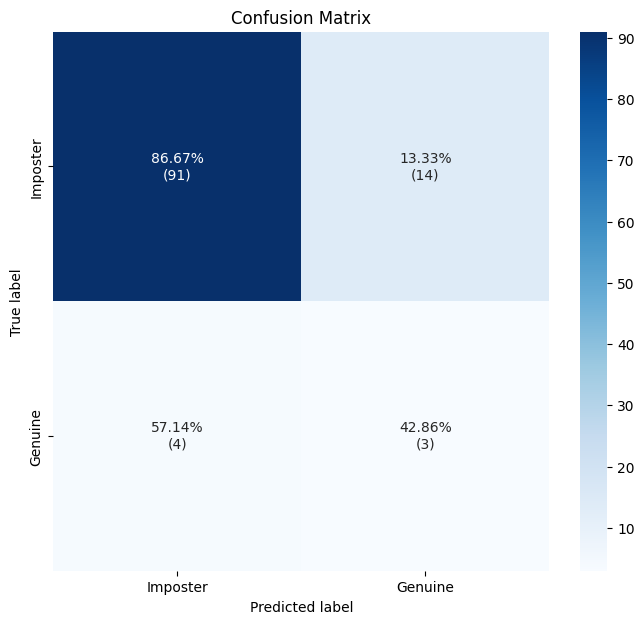

In [ ]:
# Plot Confusion matrix manually
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

tp = 3
tn = 91
fp = 14
fn = 4

# Create a 2x2 confusion matrix from the values
conf_matrix = np.array([[tn, fp],
                        [fn, tp]])

# Calculate ratios for each cell
# Avoid division by zero
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
false_negative_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Create annotation strings including both count and ratio
annotations = np.array([[
f"{100*specificity:.2f}%\n({tn})", f"{100*false_positive_rate:.2f}%\n({fp})"
],
[
f"{100*false_negative_rate:.2f}%\n({fn})", f"{100*recall:.2f}%\n({tp})"
]])

# Define the labels for the axes
class_names = ['Imposter', 'Genuine'] # For both true and predicted labels

plt.figure(figsize = (8,7))
sns.heatmap(conf_matrix, annot=annotations, fmt='s', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# ============================================================
# Genuine-only (TARGET_PID), Session 3 → CSV of predicted labels
# Columns: subject_id, session, gesture, trial, pred_label, confidence
# Uses your trained clf, templates, Z_stats, tau, and feature extractor.
# ============================================================
import re, time, pandas as pd, numpy as np
from pathlib import Path

CSV_GESTURES = {1, 3, 11, 12, 16}
OUT_PATH = f"/content/genuine_s3_predictions_{time.strftime('%Y%m%d_%H%M%S')}.csv"

# Fallbacks if not defined earlier
try:
    TOPK_K
except NameError:
    TOPK_K = 10
try:
    TRIM_FRACTION
except NameError:
    TRIM_FRACTION = 0.10

def parse_ids_from_rid(rid):
    m = re.search(r"session(\d+)_participant(\d+)_gesture(\d+)_trial(\d+)$", rid)
    return (int(m.group(1)), int(m.group(2)), int(m.group(3)), int(m.group(4))) if m else (None, None, None, None)

# Local scorer that IGNORES any global gesture filter
def trial_prob_for_stem_topk_unfiltered(stem, K=TOPK_K, trim=TRIM_FRACTION):
    Xw, _ = features_for_record_plus(stem, templates, Z_stats)
    if Xw.shape[0] == 0:
        return None
    p = clf.predict_proba(Xw)[:, 1]
    if K is not None and len(p) > 0:
        k = min(K, len(p))
        p = np.partition(p, -k)[-k:]   # top-k
    if trim is not None and 0 < trim < 0.5 and len(p) > 4:
        p = np.sort(p)
        a = int(len(p)*trim); b = len(p)-a
        p = p[a:b]
    return float(np.mean(p)) if len(p) else None

rows = []
# Genuine user: TARGET_PID, Session 3 only
for st in stems_for(TARGET_PID, (3,)):
    rid = Path(st).name
    sess, pid, gest, trial = parse_ids_from_rid(rid)
    if gest not in CSV_GESTURES:
        continue
    prob = trial_prob_for_stem_topk_unfiltered(st)
    if prob is None:
        continue
    pred = int(prob >= tau)   # predicted label using your chosen threshold τ
    rows.append({
        "subject_id": pid,
        "session": sess,
        "gesture": gest,
        "trial": trial,
        "pred_label": pred,
        "confidence": prob
    })

df = pd.DataFrame(rows).sort_values(["gesture","trial"]).reset_index(drop=True)
df.to_csv(OUT_PATH, index=False)
print(f"Saved {len(df)} rows to: {OUT_PATH}")
print(df.head(10))


Saved 35 rows to: /content/genuine_s3_predictions_20251201_212648.csv
   subject_id  session  gesture  trial  pred_label  confidence
0          38        3        1      1           1    0.669233
1          38        3        1      2           1    0.208333
2          38        3        1      3           1    0.151255
3          38        3        1      4           1    0.243328
4          38        3        1      5           0    0.004065
5          38        3        1      6           0    0.002042
6          38        3        1      7           0    0.001206
7          38        3        3      1           1    0.926858
8          38        3        3      2           1    0.705658
9          38        3        3      3           1    0.572267


#exploring other evaluation metrics

In [ ]:
import re, numpy as np
from collections import defaultdict

imp_s12 = []  # (pid, record_id, gesture, prob)
for pid in TEST_PARTICIPANTS:
    for st in stems_for(pid, (1,2)):  # test users, sessions 1 & 2
        pr = trial_prob_for_stem_topk(st, K=TOPK_K, trim=TRIM_FRACTION)
        if pr is None:
            continue  # gesture filtered out or empty
        rid = record_id(st)
        g = int(re.search(r"gesture(\d+)", rid).group(1))
        imp_s12.append((pid, rid, g, pr))

N_imp = len(imp_s12)
if N_imp == 0:
    print("No TEST impostor trials found in Sessions 1–2 (after gesture filtering).")
else:
    # FAR on these impostor trials (accept rate at threshold τ)
    imp_preds = [1 if pr >= tau else 0 for _,_,_,pr in imp_s12]
    FAR_s12 = float(np.mean(imp_preds))
    probs = np.array([pr for *_, pr in imp_s12], dtype=float)

    print(f"TEST impostors (Sessions 1–2)")
    print(f"  Trials: {N_imp}")
    print(f"  FAR = {FAR_s12*100:.2f}%   (threshold τ = {tau:.3f})")
    print(f"  prob mean = {probs.mean():.3f}   median = {np.median(probs):.3f}")

    # Per-gesture FAR
    by_g = defaultdict(list)
    for pid, rid, g, pr in imp_s12:
        by_g[g].append(pr)
    print("\nPer-gesture impostor FAR on S1–S2:")
    for g in sorted(by_g):
        vals = by_g[g]
        far_g = float(np.mean([1 if v >= tau else 0 for v in vals]))
        print(f"  G{g:02d}: N={len(vals):3d}  FAR={far_g*100:.1f}%")

    # Top offenders (highest impostor probabilities)
    worst = sorted(imp_s12, key=lambda x: x[3], reverse=True)[:10]
    print("\nTop-10 impostor trials by probability (should be < τ):")
    for pid, rid, g, pr in worst:
        flag = "  **ACCEPTED**" if pr >= tau else ""
        print(f"  P{pid:02d}  {rid}  G{g:02d}  p={pr:.3f}{flag}")

TEST impostors (Sessions 1–2)
  Trials: 1050
  FAR = 17.05%   (threshold τ = 0.243)
  prob mean = 0.124   median = 0.018

Per-gesture impostor FAR on S1–S2:
  G01: N= 70  FAR=22.9%
  G02: N= 70  FAR=14.3%
  G03: N= 70  FAR=15.7%
  G04: N= 70  FAR=22.9%
  G05: N= 70  FAR=7.1%
  G06: N= 70  FAR=14.3%
  G07: N= 70  FAR=22.9%
  G08: N= 70  FAR=21.4%
  G09: N= 70  FAR=28.6%
  G10: N= 70  FAR=5.7%
  G11: N= 70  FAR=18.6%
  G12: N= 70  FAR=8.6%
  G13: N= 70  FAR=8.6%
  G14: N= 70  FAR=21.4%
  G16: N= 70  FAR=22.9%

Top-10 impostor trials by probability (should be < τ):
  P43  session1_participant43_gesture4_trial4  G04  p=0.984  **ACCEPTED**
  P43  session2_participant43_gesture14_trial5  G14  p=0.976  **ACCEPTED**
  P43  session1_participant43_gesture9_trial1  G09  p=0.969  **ACCEPTED**
  P41  session2_participant41_gesture16_trial3  G16  p=0.964  **ACCEPTED**
  P43  session1_participant43_gesture1_trial1  G01  p=0.955  **ACCEPTED**
  P43  session2_participant43_gesture14_trial3  G14  p=0.95

# for all geature. Genuin (participant 1) and imposters(remained participants)
Per-gesture impostor FAR on S1–S2:
  G01: N= 70  FAR=2.9%
  G02: N= 70  FAR=17.1%
  G03: N= 70  FAR=15.7%
  G04: N= 70  FAR=24.3%
  G05: N= 70  FAR=14.3%
  G06: N= 70  FAR=17.1%
  G07: N= 70  FAR=15.7%
  G08: N= 70  FAR=20.0%
  G09: N= 70  FAR=7.1%
  G10: N= 70  FAR=18.6%
  G11: N= 70  FAR=0.0%
  G12: N= 70  FAR=0.0%
  G13: N= 70  FAR=57.1%
  G14: N= 70  FAR=10.0%
  G15: N= 70  FAR=22.9%
  G16: N= 70  FAR=0.0%
  G17: N= 70  FAR=7.1%

Top-10 impostor trials by probability (should be < τ):
  P40  session2_participant40_gesture3_trial1  G03  p=0.961  **ACCEPTED**
  P40  session2_participant40_gesture15_trial5  G15  p=0.956  **ACCEPTED**
  P40  session2_participant40_gesture13_trial3  G13  p=0.945  **ACCEPTED**
  P40  session2_participant40_gesture3_trial3  G03  p=0.942  **ACCEPTED**
  P40  session2_participant40_gesture3_trial6  G03  p=0.929  **ACCEPTED**
  P40  session2_participant40_gesture13_trial6  G13  p=0.923  **ACCEPTED**
  P42  session2_participant42_gesture2_trial7  G02  p=0.907  **ACCEPTED**
  P40  session2_participant40_gesture15_trial6  G15  p=0.903  **ACCEPTED**
  P40  session2_participant40_gesture15_trial3  G15  p=0.900  **ACCEPTED**
  P40  session2_participant40_gesture3_trial7  G03  p=0.896  **ACCEPTED**

#for all geature. Gen (partipant 11), Imposters
TEST impostors (Sessions 1–2)
  Trials: 1190
  FAR = 14.71%   (threshold τ = 0.307)
  prob mean = 0.113   median = 0.010

Per-gesture impostor FAR on S1–S2:
  G01: N= 70  FAR=12.9%
  G02: N= 70  FAR=27.1%
  G03: N= 70  FAR=10.0%
  G04: N= 70  FAR=12.9%
  G05: N= 70  FAR=11.4%
  G06: N= 70  FAR=4.3%
  G07: N= 70  FAR=17.1%
  G08: N= 70  FAR=14.3%
  G09: N= 70  FAR=27.1%
  G10: N= 70  FAR=12.9%
  G11: N= 70  FAR=4.3%
  G12: N= 70  FAR=5.7%
  G13: N= 70  FAR=41.4%
  G14: N= 70  FAR=17.1%
  G15: N= 70  FAR=11.4%
  G16: N= 70  FAR=10.0%
  G17: N= 70  FAR=10.0%

Top-10 impostor trials by probability (should be < τ):
  P40  session2_participant40_gesture13_trial5  G13  p=0.954  **ACCEPTED**
  P40  session2_participant40_gesture13_trial2  G13  p=0.936  **ACCEPTED**
  P42  session2_participant42_gesture13_trial1  G13  p=0.919  **ACCEPTED**
  P42  session2_participant42_gesture2_trial2  G02  p=0.907  **ACCEPTED**
  P42  session2_participant42_gesture17_trial5  G17  p=0.903  **ACCEPTED**
  P42  session2_participant42_gesture13_trial5  G13  p=0.899  **ACCEPTED**
  P40  session2_participant40_gesture13_trial7  G13  p=0.895  **ACCEPTED**
  P42  session1_participant42_gesture9_trial1  G09  p=0.890  **ACCEPTED**
  P42  session2_participant42_gesture2_trial6  G02  p=0.878  **ACCEPTED**
  P40  session1_participant40_gesture13_trial3  G13  p=0.874  **ACCEPTED**

In [ ]:
# ===========================================
# Extra evaluation metrics (trial-level, Session 3)
# - ROC AUC
# - EER (+ threshold)
# - HTER at chosen τ
# - PR-AUC (Average Precision)
# - Brier score
# - minDCF at priors {0.5, 0.05, 0.01}
# - Plots: ROC, DET, Reliability (calibration)
# ===========================================
from sklearn.metrics import roc_curve, auc, average_precision_score, brier_score_loss

# ---- Gather S3 trial probabilities (recompute to be safe) ----
def s3_trial_probs():
    gen_probs = []
    for st in stems_for(TARGET_PID, (3,)):
        pr = trial_prob_for_stem_topk(st, K=TOPK_K, trim=TRIM_FRACTION)
        if pr is not None: gen_probs.append(pr)
    imp_probs = []
    for pid in TEST_PARTICIPANTS:
        for st in stems_for(pid, (3,)):
            pr = trial_prob_for_stem_topk(st, K=TOPK_K, trim=TRIM_FRACTION)
            if pr is not None: imp_probs.append(pr)
    y = np.r_[np.ones(len(gen_probs)), np.zeros(len(imp_probs))]
    s = np.r_[gen_probs, imp_probs]
    return y, s, np.array(gen_probs), np.array(imp_probs)

y, scores, gen_probs, imp_probs = s3_trial_probs()
assert y.size and scores.size, "No S3 trials found for evaluation."

In [ ]:
# ---- ROC AUC & EER ----
fpr, tpr, thr = roc_curve(y, scores)
roc_auc = auc(fpr, tpr)

In [ ]:
# EER: threshold where FNR == FPR
fnr = 1 - tpr
eer_idx = np.nanargmin(np.abs(fnr - fpr))
eer = 0.5 * (fnr[eer_idx] + fpr[eer_idx])
tau_eer = thr[eer_idx]

In [ ]:
# ---- Metrics at your chosen τ ----
FRR_at_tau = float(np.mean(scores[y==1] < tau)) if np.any(y==1) else np.nan
FAR_at_tau = float(np.mean(scores[y==0] >= tau)) if np.any(y==0) else np.nan
HTER_at_tau = 0.5*(FRR_at_tau + FAR_at_tau)

In [ ]:
# ---- PR-AUC & Brier ----
pr_auc = average_precision_score(y, scores)   # AP; higher is better
brier = brier_score_loss(y, scores)           # lower is better


In [ ]:
# ---- minDCF (C_miss=C_fa=1) for priors of interest ----
def min_dcf(y, s, p_tar=0.01, c_miss=1.0, c_fa=1.0):
    # sweep all thresholds
    fpr, tpr, thr = roc_curve(y, s)
    fnr = 1 - tpr
    c_det = c_miss * p_tar * fnr + c_fa * (1 - p_tar) * fpr
    c_def = min(c_miss * p_tar, c_fa * (1 - p_tar))  # normalization
    return float(np.min(c_det) / (c_def + 1e-12))

minDCF_50  = min_dcf(y, scores, p_tar=0.50)
minDCF_05  = min_dcf(y, scores, p_tar=0.05)
minDCF_01  = min_dcf(y, scores, p_tar=0.01)

In [ ]:
# ---- minDCF (C_miss=C_fa=1) for priors of interest ----
def min_dcf(y, s, p_tar=0.01, c_miss=1.0, c_fa=1.0):
    # sweep all thresholds
    fpr, tpr, thr = roc_curve(y, s)
    fnr = 1 - tpr
    c_det = c_miss * p_tar * fnr + c_fa * (1 - p_tar) * fpr
    c_def = min(c_miss * p_tar, c_fa * (1 - p_tar))  # normalization
    return float(np.min(c_det) / (c_def + 1e-12))

minDCF_50  = min_dcf(y, scores, p_tar=0.50)
minDCF_05  = min_dcf(y, scores, p_tar=0.05)
minDCF_01  = min_dcf(y, scores, p_tar=0.01)

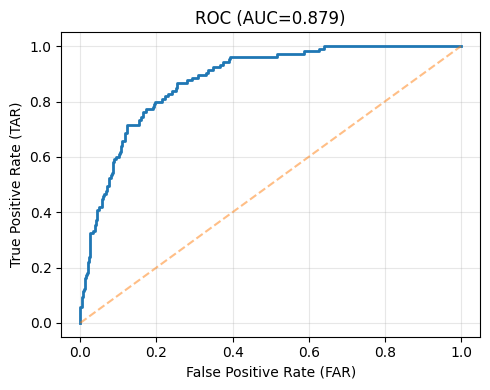

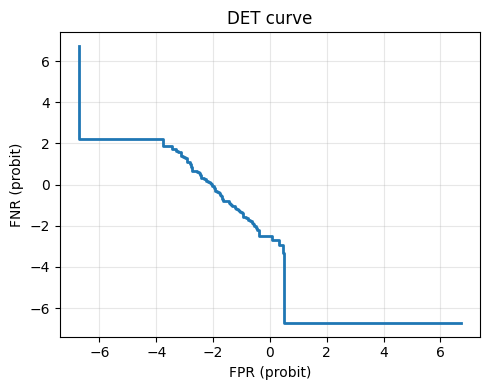

In [ ]:
from matplotlib import pyplot as plt
# ---- Plots: ROC, DET, Reliability ----
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],'--',alpha=0.5)
plt.xlabel("False Positive Rate (FAR)"); plt.ylabel("True Positive Rate (TAR)")
plt.title(f"ROC (AUC={roc_auc:.3f})"); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# DET (FNR vs FPR, probit axes)
from scipy.stats import norm
def _probit(x):
    x = np.clip(x, 1e-6, 1-1e-6)
    return np.sqrt(2)*norm.ppf(x)  # probit scaling
plt.figure(figsize=(5,4))
plt.plot(_probit(fpr), _probit(fnr), lw=2)
plt.xlabel("FPR (probit)"); plt.ylabel("FNR (probit)")
plt.title("DET curve"); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


ECE (10-bin)      : 0.0825


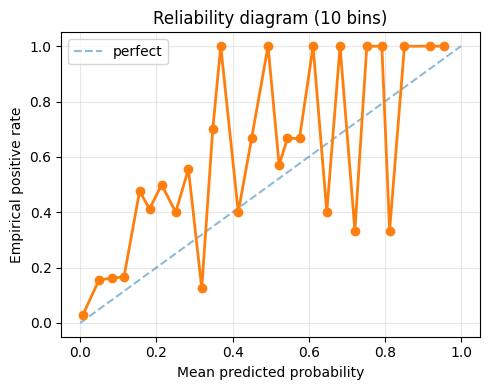

In [ ]:
# Reliability (calibration) diagram
bins = np.linspace(0,1,31)
bin_ids = np.digitize(scores, bins) - 1
acc = []; conf = []
for b in range(len(bins)-1):
    m = bin_ids == b
    if np.any(m):
        acc.append(np.mean(y[m]))
        conf.append(np.mean(scores[m]))
ece = np.sum([abs(a-c)*np.mean(bin_ids==i) for i,(a,c) in enumerate(zip(acc,conf))])
print(f"ECE (10-bin)      : {ece:.4f}")

plt.figure(figsize=(5,4))
plt.plot([0,1],[0,1],'--',alpha=0.5,label="perfect")
plt.plot(conf, acc, marker='o', lw=2)
plt.xlabel("Mean predicted probability"); plt.ylabel("Empirical positive rate")
plt.title("Reliability diagram (10 bins)")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

#Plotting 2d scattering of a pair of rings

In [ ]:
# -------------------- BUILD TEMPLATES --------------------
templates = build_target_templates(TARGET_PID, sessions=(1,2))
# ---------------- Z-STATS ----------------
Z_stats = compute_z_stats(templates)

Templates P38:   0%|          | 0/238 [00:00<?, ?it/s]

Records — genuine: 105 | impostor: 105 | rings used: ['WP', 'FD', 'WD', 'FP']
[Orientation] window sign=+1, trial sign=+1 (higher ⇒ more genuine)


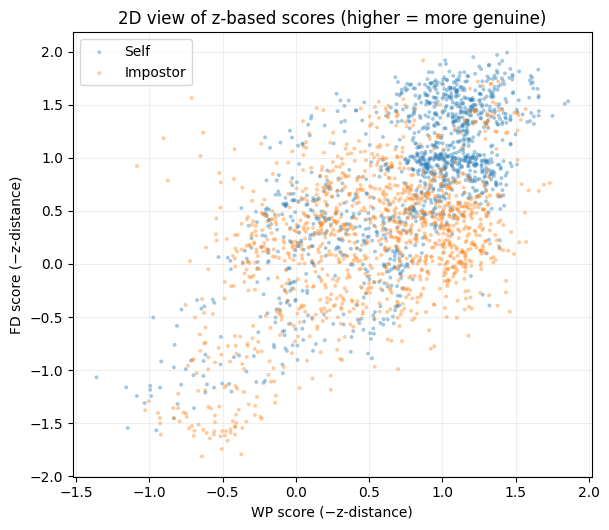

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# =======================
# CONFIG
# =======================
ENROLL_PARTICIPANT = 38
IMPOSTOR_PARTICIPANT = 4     # set to None to skip impostor probes
SESS_ENROLL  = [1, 2]        # enrollment (and training) sessions
SESS_PROBE   = [3]           # where we evaluate (genuine + impostor)


# ---- use 4 rings (only those present) and weights ----
RINGS = [r for r in ("WP","FD","WD","FP") if r in templates]
RING_WEIGHTS = {"WP":0.45, "FD":0.35, "FP":0.15, "WD":0.05}  # tweak or learn on dev

def zdistances_for(participant, sessions, rings):
    out = []
    for stem in stems_for(participant, sessions):
        rid = pathlib.Path(stem).name
        d = ring_distances_for_record(stem, templates)  # raw distances (per-window)
        rec = {"id": rid, "rings": {}}
        ok = False
        for r in rings:
            if r not in d:
                continue
            mu, sd = Z_stats.get(r, (0.0,1.0))
            zr = (np.asarray(d[r], np.float32) - mu) / (sd + 1e-8)
            if zr.size:
                rec["rings"][r] = zr
                ok = True
        if ok:
            out.append(rec)
    return out

# Collect genuine/impostor on your probe sessions
genuine  = zdistances_for(ENROLL_PARTICIPANT, SESS_PROBE, RINGS)
impostor = zdistances_for(IMPOSTOR_PARTICIPANT, SESS_PROBE, RINGS) if 'IMPOSTOR_PARTICIPANT' in globals() and IMPOSTOR_PARTICIPANT else []

print(f"Records — genuine: {len(genuine)} | impostor: {len(impostor)} | rings used: {RINGS}")

def fused_z_windows(rec, rings=RINGS, weights=RING_WEIGHTS):
    if not rec["rings"]: return np.array([])
    nwin = min(len(rec["rings"][r]) for r in rings if r in rec["rings"])
    if nwin == 0: return np.array([])
    Z = np.stack([rec["rings"][r][:nwin] for r in rings if r in rec["rings"]], axis=1)  # (nwin, n_rings)
    W = np.array([weights.get(r,0.0) for r in rings if r in rec["rings"]], np.float32)
    return (Z * W[None,:]).sum(axis=1)  # fused z (smaller ⇒ more genuine)

def build_scores(genuine, impostor, agg=None):
    y, s = [], []
    if agg is None:
        for rec in genuine:
            v = fused_z_windows(rec); y += [1]*len(v); s += v.tolist()
        for rec in impostor:
            v = fused_z_windows(rec); y += [0]*len(v); s += v.tolist()
    else:
        for rec in genuine:
            v = fused_z_windows(rec);
            if v.size: y.append(1); s.append(np.median(v) if agg=="median" else np.mean(v))
        for rec in impostor:
            v = fused_z_windows(rec);
            if v.size: y.append(0); s.append(np.median(v) if agg=="median" else np.mean(v))
    return np.array(y), np.array(s)

# --- Build raw fused z (lower should be more genuine) ---
y_w, z_w = build_scores(genuine, impostor, agg=None)
y_r, z_r = build_scores(genuine, impostor, agg="median")

# --- Auto-orient: create score where higher ⇒ more genuine ---
def orient_score(y, z):
    if y.size == 0: return z, +1
    med_pos = np.median(z[y==1]) if np.any(y==1) else np.nan
    med_neg = np.median(z[y==0]) if np.any(y==0) else np.nan
    # if impostor median < genuine median, flip sign so higher ⇒ more genuine
    flip = (med_neg < med_pos)
    s = (-z) if flip else z
    return s, (-1 if flip else +1)

s_w, sign_w = orient_score(y_w, z_w)
s_r, sign_r = orient_score(y_r, z_r)
print(f"[Orientation] window sign={sign_w:+d}, trial sign={sign_r:+d} (higher ⇒ more genuine)")

# --- ROC helpers ---
def plot_roc(y, s, title):
    if y.size == 0 or len(np.unique(y)) < 2:
        print(f"{title}: not enough classes.")
        return
    fpr, tpr, thr = skm.roc_curve(y, s)      # use module namespace
    eer_idx = np.argmin(np.abs(1 - tpr - fpr))
    eer = 0.5 * (fpr[eer_idx] + (1 - tpr[eer_idx]))
    auc_val = skm.auc(fpr, tpr)              # safe: skm.auc
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, lw=2, label=f"AUC={auc_val:.3f}, EER≈{eer*100:.1f}%")
    plt.plot([0,1],[0,1],'--',color='gray',alpha=0.5)
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(title)
    plt.legend(); plt.grid(alpha=0.2); plt.tight_layout(); plt.show()
    print(f"{title}: AUC={auc_val:.3f}, EER≈{eer*100:.2f}%")

# --- 2D scatter with −z axes (e.g., WP vs FD) ---
AXES_RINGS = tuple([r for r in ("WP","FD") if r in RINGS])  # change to ("WP","FP") etc.
if len(AXES_RINGS) == 2:
    def pair_points(recs, r1, r2):
        pts = []
        for rec in recs:
            if r1 in rec["rings"] and r2 in rec["rings"]:
                n = min(len(rec["rings"][r1]), len(rec["rings"][r2]))
                pts.append(np.c_[-rec["rings"][r1][:n], -rec["rings"][r2][:n]])
        return np.vstack(pts) if pts else np.zeros((0,2))
    Xi = pair_points(impostor, AXES_RINGS[0], AXES_RINGS[1])
    Xg = pair_points(genuine, AXES_RINGS[0], AXES_RINGS[1])
    plt.figure(figsize=(6.2,5.4))
    if Xg.size: plt.scatter(Xg[:,0], Xg[:,1], s=8, alpha=0.4, label="Self", edgecolor='none')
    if Xi.size: plt.scatter(Xi[:,0], Xi[:,1], s=8, alpha=0.4, label="Impostor", edgecolor='none')
    plt.xlabel(f"{AXES_RINGS[0]} score (−z-distance)")
    plt.ylabel(f"{AXES_RINGS[1]} score (−z-distance)")
    plt.title("2D view of z-based scores (higher = more genuine)")
    plt.grid(alpha=0.2); plt.legend(); plt.tight_layout(); plt.show()
else:
    print("2D plot skipped: need two chosen rings present.")

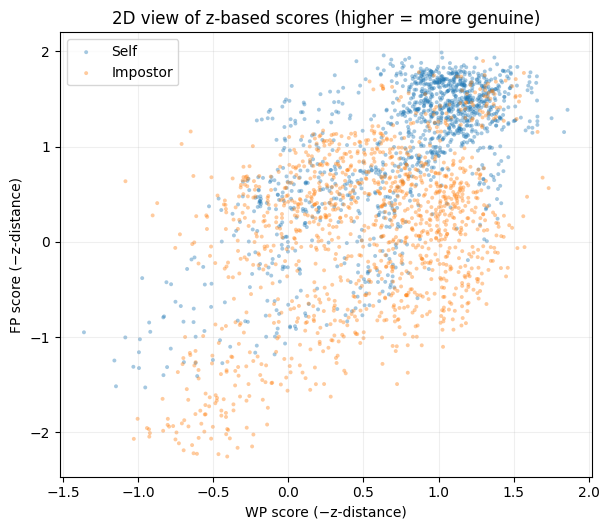

In [ ]:
# --- 2D scatter with −z axes (e.g., WP vs FD) ---
AXES_RINGS = tuple([r for r in ("WP","FP") if r in RINGS])  # change to ("WP","FP") etc.
if len(AXES_RINGS) == 2:
    def pair_points(recs, r1, r2):
        pts = []
        for rec in recs:
            if r1 in rec["rings"] and r2 in rec["rings"]:
                n = min(len(rec["rings"][r1]), len(rec["rings"][r2]))
                pts.append(np.c_[-rec["rings"][r1][:n], -rec["rings"][r2][:n]])
        return np.vstack(pts) if pts else np.zeros((0,2))
    Xi = pair_points(impostor, AXES_RINGS[0], AXES_RINGS[1])
    Xg = pair_points(genuine, AXES_RINGS[0], AXES_RINGS[1])
    plt.figure(figsize=(6.2,5.4))
    if Xg.size: plt.scatter(Xg[:,0], Xg[:,1], s=8, alpha=0.4, label="Self", edgecolor='none')
    if Xi.size: plt.scatter(Xi[:,0], Xi[:,1], s=8, alpha=0.4, label="Impostor", edgecolor='none')
    plt.xlabel(f"{AXES_RINGS[0]} score (−z-distance)")
    plt.ylabel(f"{AXES_RINGS[1]} score (−z-distance)")
    plt.title("2D view of z-based scores (higher = more genuine)")
    plt.grid(alpha=0.2); plt.legend(); plt.tight_layout(); plt.show()
else:
    print("2D plot skipped: need two chosen rings present.")

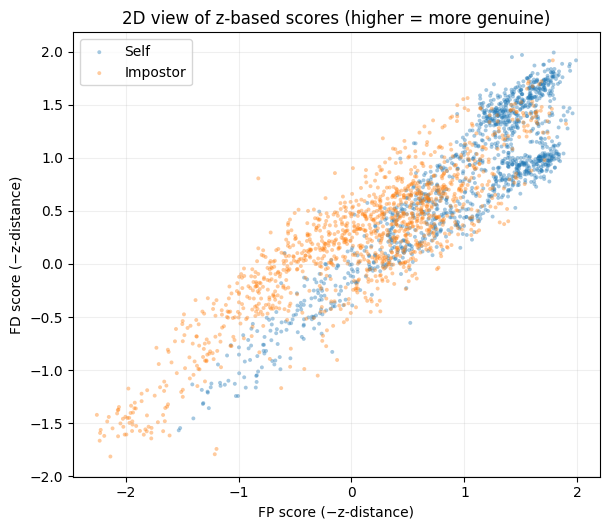

In [ ]:
# --- 2D scatter with −z axes (e.g., WP vs FD) ---
AXES_RINGS = tuple([r for r in ("FP","FD") if r in RINGS])  # change to ("WP","FP") etc.
if len(AXES_RINGS) == 2:
    def pair_points(recs, r1, r2):
        pts = []
        for rec in recs:
            if r1 in rec["rings"] and r2 in rec["rings"]:
                n = min(len(rec["rings"][r1]), len(rec["rings"][r2]))
                pts.append(np.c_[-rec["rings"][r1][:n], -rec["rings"][r2][:n]])
        return np.vstack(pts) if pts else np.zeros((0,2))
    Xi = pair_points(impostor, AXES_RINGS[0], AXES_RINGS[1])
    Xg = pair_points(genuine, AXES_RINGS[0], AXES_RINGS[1])
    plt.figure(figsize=(6.2,5.4))
    if Xg.size: plt.scatter(Xg[:,0], Xg[:,1], s=8, alpha=0.4, label="Self", edgecolor='none')
    if Xi.size: plt.scatter(Xi[:,0], Xi[:,1], s=8, alpha=0.4, label="Impostor", edgecolor='none')
    plt.xlabel(f"{AXES_RINGS[0]} score (−z-distance)")
    plt.ylabel(f"{AXES_RINGS[1]} score (−z-distance)")
    plt.title("2D view of z-based scores (higher = more genuine)")
    plt.grid(alpha=0.2); plt.legend(); plt.tight_layout(); plt.show()
else:
    print("2D plot skipped: need two chosen rings present.")

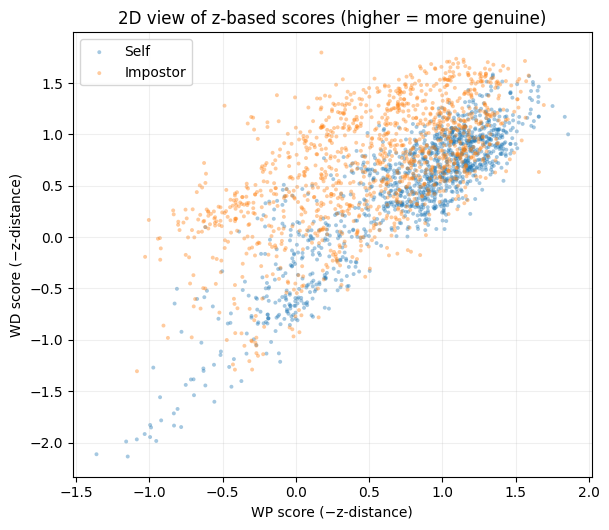

In [ ]:
# --- 2D scatter with −z axes (e.g., WP vs FD) ---
AXES_RINGS = tuple([r for r in ("WP","WD") if r in RINGS])  # change to ("WP","FP") etc.
if len(AXES_RINGS) == 2:
    def pair_points(recs, r1, r2):
        pts = []
        for rec in recs:
            if r1 in rec["rings"] and r2 in rec["rings"]:
                n = min(len(rec["rings"][r1]), len(rec["rings"][r2]))
                pts.append(np.c_[-rec["rings"][r1][:n], -rec["rings"][r2][:n]])
        return np.vstack(pts) if pts else np.zeros((0,2))
    Xi = pair_points(impostor, AXES_RINGS[0], AXES_RINGS[1])
    Xg = pair_points(genuine, AXES_RINGS[0], AXES_RINGS[1])
    plt.figure(figsize=(6.2,5.4))
    if Xg.size: plt.scatter(Xg[:,0], Xg[:,1], s=8, alpha=0.4, label="Self", edgecolor='none')
    if Xi.size: plt.scatter(Xi[:,0], Xi[:,1], s=8, alpha=0.4, label="Impostor", edgecolor='none')
    plt.xlabel(f"{AXES_RINGS[0]} score (−z-distance)")
    plt.ylabel(f"{AXES_RINGS[1]} score (−z-distance)")
    plt.title("2D view of z-based scores (higher = more genuine)")
    plt.grid(alpha=0.2); plt.legend(); plt.tight_layout(); plt.show()
else:
    print("2D plot skipped: need two chosen rings present.")

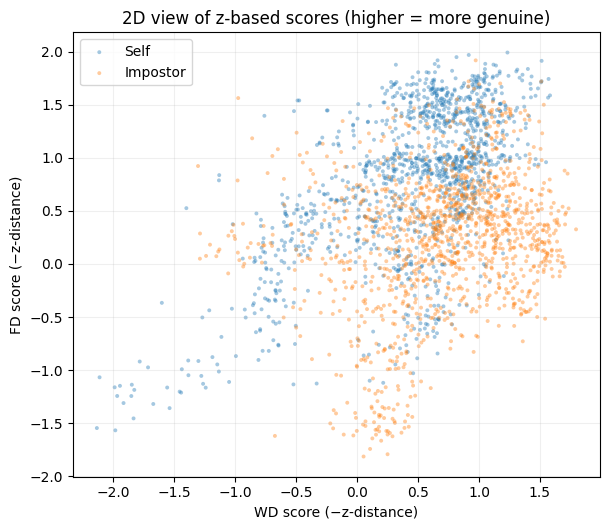

In [ ]:
# --- 2D scatter with −z axes (e.g., WP vs FD) ---
AXES_RINGS = tuple([r for r in ("WD","FD") if r in RINGS])  # change to ("WP","FP") etc.
if len(AXES_RINGS) == 2:
    def pair_points(recs, r1, r2):
        pts = []
        for rec in recs:
            if r1 in rec["rings"] and r2 in rec["rings"]:
                n = min(len(rec["rings"][r1]), len(rec["rings"][r2]))
                pts.append(np.c_[-rec["rings"][r1][:n], -rec["rings"][r2][:n]])
        return np.vstack(pts) if pts else np.zeros((0,2))
    Xi = pair_points(impostor, AXES_RINGS[0], AXES_RINGS[1])
    Xg = pair_points(genuine, AXES_RINGS[0], AXES_RINGS[1])
    plt.figure(figsize=(6.2,5.4))
    if Xg.size: plt.scatter(Xg[:,0], Xg[:,1], s=8, alpha=0.4, label="Self", edgecolor='none')
    if Xi.size: plt.scatter(Xi[:,0], Xi[:,1], s=8, alpha=0.4, label="Impostor", edgecolor='none')
    plt.xlabel(f"{AXES_RINGS[0]} score (−z-distance)")
    plt.ylabel(f"{AXES_RINGS[1]} score (−z-distance)")
    plt.title("2D view of z-based scores (higher = more genuine)")
    plt.grid(alpha=0.2); plt.legend(); plt.tight_layout(); plt.show()
else:
    print("2D plot skipped: need two chosen rings present.")

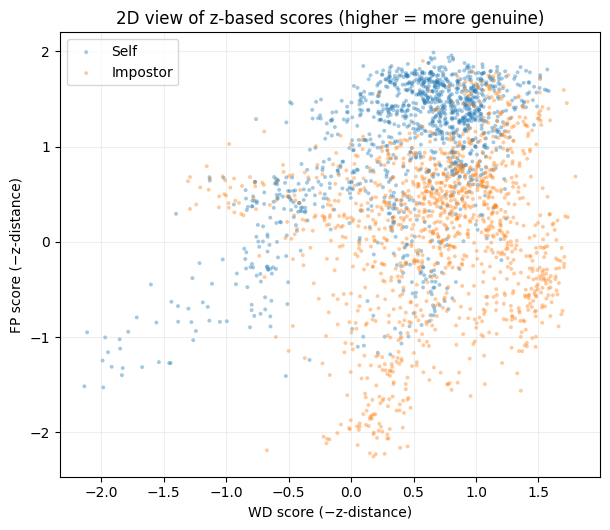

In [ ]:
# --- 2D scatter with −z axes (e.g., WP vs FD) ---
AXES_RINGS = tuple([r for r in ("WD","FP") if r in RINGS])  # change to ("WP","FP") etc.
if len(AXES_RINGS) == 2:
    def pair_points(recs, r1, r2):
        pts = []
        for rec in recs:
            if r1 in rec["rings"] and r2 in rec["rings"]:
                n = min(len(rec["rings"][r1]), len(rec["rings"][r2]))
                pts.append(np.c_[-rec["rings"][r1][:n], -rec["rings"][r2][:n]])
        return np.vstack(pts) if pts else np.zeros((0,2))
    Xi = pair_points(impostor, AXES_RINGS[0], AXES_RINGS[1])
    Xg = pair_points(genuine, AXES_RINGS[0], AXES_RINGS[1])
    plt.figure(figsize=(6.2,5.4))
    if Xg.size: plt.scatter(Xg[:,0], Xg[:,1], s=8, alpha=0.4, label="Self", edgecolor='none')
    if Xi.size: plt.scatter(Xi[:,0], Xi[:,1], s=8, alpha=0.4, label="Impostor", edgecolor='none')
    plt.xlabel(f"{AXES_RINGS[0]} score (−z-distance)")
    plt.ylabel(f"{AXES_RINGS[1]} score (−z-distance)")
    plt.title("2D view of z-based scores (higher = more genuine)")
    plt.grid(alpha=0.2); plt.legend(); plt.tight_layout(); plt.show()
else:
    print("2D plot skipped: need two chosen rings present.")

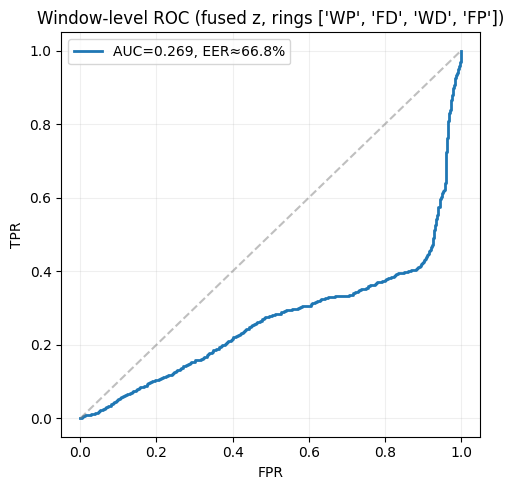

Window-level ROC (fused z, rings ['WP', 'FD', 'WD', 'FP']): AUC=0.269, EER≈66.83%


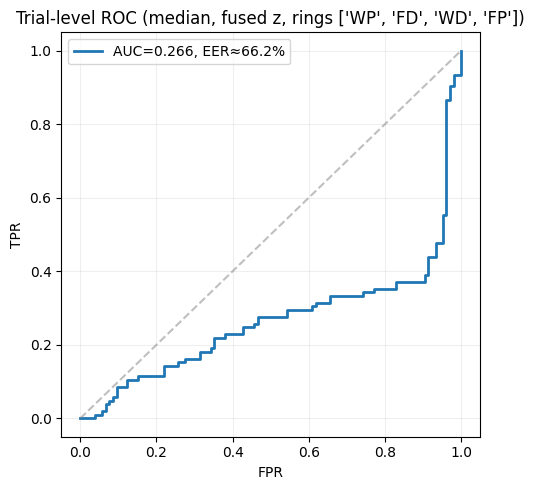

Trial-level ROC (median, fused z, rings ['WP', 'FD', 'WD', 'FP']): AUC=0.266, EER≈66.19%


In [ ]:
import sklearn.metrics as skm
plot_roc(y_w, s_w, f"Window-level ROC (fused z, rings {RINGS})")
plot_roc(y_r, s_r, f"Trial-level ROC (median, fused z, rings {RINGS})")

#Statistical Tests

In [ ]:
import numpy as np, pandas as pd, re
from pathlib import Path
from scipy import stats
from sklearn.metrics import roc_auc_score
import statsmodels.formula.api as smf

RINGS_TEST = ["WP","FD","FP","WD"]
RING_WEIGHTS_TEST = {"WP":0.45, "FD":0.35, "FP":0.15, "WD":0.05}
N_BOOT = 500
RNG = np.random.default_rng(13)

# --- small helpers ---
def parse_ids_from_rid(rid):
    m = re.search(r"session(\d+)_participant(\d+)_gesture(\d+)_trial(\d+)$", rid)
    return (int(m.group(1)), int(m.group(2)), int(m.group(3)), int(m.group(4))) if m else (None, None, None, None)

def strided_windows(X, win, hop):
    T, C = X.shape
    if T < win: return np.zeros((0,win,C), dtype=X.dtype)
    s0, s1 = X.strides
    n = 1 + (T - win)//hop
    return np.lib.stride_tricks.as_strided(X, shape=(n,win,C), strides=(hop*s0, s0, s1))

# --- Build templates for the selected rings (from target S1–2) ---
def build_templates_for_rings(pid, sessions, rings):
    covs_by_ring = {}
    for st in stems_for(pid, sessions):
        data, names, fs = read_record(st)
        idxs = ring_indices(names)  # dict ring -> channel indices
        for r in rings:
            if r not in idxs:
                continue
            X = bandpass_car(data, fs, idxs[r])
            env = cheap_env(X, fs)
            keep, _, _ = gate_idx(env, fs, WIN_SEC, HOP_SEC, GATE_TOP)
            if 'MAX_WIN_PER_RECORD' in globals() and MAX_WIN_PER_RECORD and keep.size > MAX_WIN_PER_RECORD:
                keep = keep[-MAX_WIN_PER_RECORD:]
            # window covariances
            win, hop = int(WIN_SEC*fs), int(HOP_SEC*fs)
            W = strided_windows(X, win, hop)
            covs = []
            for k in keep:
                w = W[k] - W[k].mean(axis=0, keepdims=True)
                covs.append(lw_cov(w))
            if covs:
                covs_by_ring.setdefault(r, []).extend(covs)
    if not covs_by_ring:
        raise RuntimeError("No covariances built; check rings/files.")
    return {r: logeuclid_template(covs_by_ring[r], robust="median") for r in covs_by_ring}

# --- Z-stats from TRAIN impostors for chosen rings ---
def compute_z_stats_for_templates(templates):
    imp_pids = [p for p in TRAIN_PARTICIPANTS if p != TARGET_PID]
    vals = {r: [] for r in templates}
    for pid in imp_pids:
        for st in stems_for(pid, (1,2)):
            d = ring_distances_for_record(st, templates)  # uses gating/MAX_WIN if your helper did
            for r in templates:
                if r in d: vals[r].append(d[r])
    Z = {}
    for r in templates:
        if vals[r]:
            v = np.concatenate(vals[r])
            Z[r] = (float(np.mean(v)), float(np.std(v) + 1e-8))
        else:
            Z[r] = (0.0, 1.0)
    return Z

def trial_z_medians(stem, templates, Z_stats, rings):
    d = ring_distances_for_record(stem, templates)
    out = {}
    for r in rings:
        if r in d and len(d[r])>0:
            mu, sd = Z_stats.get(r, (0.0,1.0))
            z = (d[r] - mu) / (sd + 1e-8)
            out[r] = float(np.median(z))
    return out

def cliffs_delta(x, y):
    x = np.asarray(x); y = np.asarray(y)
    gt = np.sum(x[:,None] >  y[None,:])
    lt = np.sum(x[:,None] <  y[None,:])
    return (gt - lt) / (x.size * y.size + 1e-12)

def boot_ci(func, a, b, iters=1000, alpha=0.05):
    vals = []
    n1, n2 = len(a), len(b)
    for _ in range(iters):
        s1 = a[RNG.integers(0, n1, n1)]
        s2 = b[RNG.integers(0, n2, n2)]
        vals.append(func(s1, s2))
    return float(np.quantile(vals, alpha/2)), float(np.quantile(vals, 1-alpha/2))

def boot_auc(y, s, iters=1000):
    vals = []
    n = len(y)
    for _ in range(iters):
        idx = RNG.integers(0, n, n)
        if len(np.unique(y[idx])) < 2:  # skip degenerate resample
            continue
        vals.append(roc_auc_score(y[idx], s[idx]))
    return np.quantile(vals, [0.025, 0.975])

# --------- Build templates & Z for these rings ----------
templates_test = build_templates_for_rings(TARGET_PID, (1,2), RINGS_TEST)
Z_stats_test   = compute_z_stats_for_templates(templates_test)

# --------- Collect Session 3 trial table ----------
# If you set GESTURES_INCLUDE_EVAL earlier, it will be respected; set to None to include all
rows = []

# target S3
for st in stems_for(TARGET_PID, (3,)):
    rid = Path(st).name
    s,p,g,t = parse_ids_from_rid(rid)
    if 'GESTURES_INCLUDE_EVAL' in globals() and GESTURES_INCLUDE_EVAL and g not in GESTURES_INCLUDE_EVAL:
        continue
    zm = trial_z_medians(st, templates_test, Z_stats_test, RINGS_TEST)
    if not zm:
        continue
    z_fused = sum(RING_WEIGHTS_TEST[r]*zm[r] for r in zm if r in RING_WEIGHTS_TEST)
    rows.append({"participant": p, "session": s, "gesture": g, "trial": t,
                 "label": 1, "z_fused": z_fused, **{f"z_{r}": zm.get(r, np.nan) for r in RINGS_TEST}})

# impostors S3
for pid in TEST_PARTICIPANTS:
    for st in stems_for(pid, (3,)):
        rid = Path(st).name
        s,p,g,t = parse_ids_from_rid(rid)
        if 'GESTURES_INCLUDE_EVAL' in globals() and GESTURES_INCLUDE_EVAL and g not in GESTURES_INCLUDE_EVAL:
            continue
        zm = trial_z_medians(st, templates_test, Z_stats_test, RINGS_TEST)
        if not zm:
            continue
        z_fused = sum(RING_WEIGHTS_TEST[r]*zm[r] for r in zm if r in RING_WEIGHTS_TEST)
        rows.append({"participant": p, "session": s, "gesture": g, "trial": t,
                     "label": 0, "z_fused": z_fused, **{f"z_{r}": zm.get(r, np.nan) for r in RINGS_TEST}})

df = pd.DataFrame(rows)
assert len(df), "No Session 3 trials found for the selected rings."

# Direction: smaller z => more genuine; define score so higher = more genuine
df["score_fused"] = -df["z_fused"]
for r in RINGS_TEST:
    if f"z_{r}" in df.columns:
        df[f"score_{r}"] = -df[f"z_{r}"]

# --------- Global tests on fused z ---------
z_target = df.loc[df.label==1, "z_fused"].values
z_impost = df.loc[df.label==0, "z_fused"].values

U, p_mwu = stats.mannwhitneyu(z_target, z_impost, alternative="less")
cd = cliffs_delta(z_target, z_impost)
cd_lo, cd_hi = boot_ci(cliffs_delta, z_target, z_impost, iters=N_BOOT)

y = df["label"].values
s = df["score_fused"].values
auc_trial = roc_auc_score(y, s)
auc_lo, auc_hi = boot_auc(y, s, iters=N_BOOT)

groups = [g["z_fused"].values for _, g in df.groupby("participant")]
kw_stat, kw_p = stats.kruskal(*groups)

# Mixed effects: z_fused ~ label + (1|participant)
df_m = df.copy()
md = smf.mixedlm("z_fused ~ label", data=df_m, groups=df_m["participant"])
mfit = md.fit(reml=True, method="lbfgs", disp=False)
coef = float(mfit.params["label"]); pval = float(mfit.pvalues["label"])

print("=== Selected rings test (WP, FD, FP) on Session 3 trials ===")
print(f"N target = {(df.label==1).sum()} | N impostor = {(df.label==0).sum()}")
print(f"Mann–Whitney U (target < impostor) on z_fused: U={U:.1f}, p={p_mwu:.3e}")
print(f"Cliff's delta on z_fused: {cd:.3f}  95% CI [{cd_lo:.3f}, {cd_hi:.3f}]")
print(f"Trial ROC AUC (score = -z_fused): {auc_trial:.3f}  95% CI [{auc_lo:.3f}, {auc_hi:.3f}]")
print(f"Kruskal–Wallis across participants (z_fused): H={kw_stat:.2f}, p={kw_p:.3e}")
print(f"Mixed-effects (z_fused ~ label + (1|participant)): coef(label)={coef:.4f}, p={pval:.3e}")

# --------- Per-ring tests (so you can see which ring is strongest) ----------
print("\nPer-ring Mann–Whitney & AUC:")
for r in RINGS_TEST:
    col = f"z_{r}"
    if col not in df.columns:
        continue
    zt = df.loc[df.label==1, col].dropna().values
    zi = df.loc[df.label==0, col].dropna().values
    if len(zt)==0 or len(zi)==0:
        print(f"  {r}: insufficient data")
        continue
    U_r, p_r = stats.mannwhitneyu(zt, zi, alternative="less")
    s_r = (-df[col]).values
    y_r = df["label"].values
    # drop NaNs for AUC
    m = ~np.isnan(s_r)
    auc_r = roc_auc_score(y_r[m], s_r[m])
    print(f"  {r}: U={U_r:.1f}, p={p_r:.3e}, AUC={auc_r:.3f}")

=== Selected rings test (WP, FD, FP) on Session 3 trials ===
N target = 105 | N impostor = 525
Mann–Whitney U (target < impostor) on z_fused: U=18052.0, p=1.163e-08
Cliff's delta on z_fused: -0.345  95% CI [-0.452, -0.227]
Trial ROC AUC (score = -z_fused): 0.673  95% CI [0.615, 0.728]
Kruskal–Wallis across participants (z_fused): H=252.91, p=1.306e-52
Mixed-effects (z_fused ~ label + (1|participant)): coef(label)=-0.3456, p=5.261e-01

Per-ring Mann–Whitney & AUC:
  WP: U=21443.0, p=1.628e-04, AUC=0.611
  FD: U=18995.0, p=2.428e-07, AUC=0.655
  FP: U=14567.0, p=1.149e-14, AUC=0.736
  WD: U=27314.0, p=4.421e-01, AUC=0.505
